In [1]:
#Import Modules
import psrchive
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, find_peaks, peak_widths
from scipy.optimize import curve_fit
import scipy.optimize as opt
from scipy.cluster.vq import kmeans, vq
import scipy.stats as stats
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import numpy.ma as ma

In [2]:
def Read_File(file_path, dedisperse = True):
    File = psrchive.Archive_load(file_path)
    File.tscrunch()
    if dedisperse == True:
        File.dedisperse()
    File.pscrunch()
    File.remove_baseline()
    dm = File.get_dispersion_measure()
    center_freq = File.get_centre_frequency()
    integration = File.get_first_Integration()
    period = integration.get_folding_period()
    File_Data = File.get_data()
    pulse = File_Data[0,0,:] #Select usable part of data
    
    #Get a list of the frequencies
    freq_mhz_table = File.get_frequency_table()
    freq_mhz = freq_mhz_table[0]
    
    
    return(pulse, freq_mhz, dm, center_freq, period)

In [3]:
def Select_Off_Pulse(File_Data, On_Pulse_Start, On_Pulse_Stop):
    #Length of freq_pulse
    len_arr = len(File_Data)
    #Create a range of zeros for the data that is removed.
    len_on_pulse = On_Pulse_Stop - On_Pulse_Start
    buckets = [np.nan] * len_on_pulse
    #Select only off-pulse channels
    off_pulse = []
    for i in range(0,len_arr):
        off_pulse.append(np.concatenate((File_Data[i][:On_Pulse_Start], buckets, File_Data[i][On_Pulse_Stop:])))
    return(off_pulse)

In [4]:
def root_mean_squared(Data):
    rms_value = np.sqrt(np.nanmean(Data**2))
    return(rms_value)

In [5]:
def Calculate_Stats(Data):
    #Create lists
    median_arr = []
    mean_arr = []
    std_arr = []
    sum_arr = []
    kurtosis_arr = []
    
    #Calculate the length of the array:
    array_length = len(Data)
    
    for i in range(0,array_length):
        #Calculate median
        median_arr.append(np.nanmedian(Data[i]))
        #Calculate mean for every channel
        mean_arr.append(np.nanmean(Data[i]))
        #Calculate standard deviation for every channel
        std_arr.append(np.nanstd(Data[i]))
        #Calculate sum for every channel
        sum_arr.append(np.nansum(Data[i]))
        #Calculate kurtosis for every channel
        kurtosis_arr.append(stats.kurtosis(Data[i], nan_policy='omit'))
    return(median_arr, mean_arr, std_arr, sum_arr, kurtosis_arr)

In [6]:
def Calculate_4Stats(Data):
    median_arr = []
    std_arr = []
    kurtosis_arr = []
    skew_arr = []
    
    #Calculate the length of the array:
    array_length = len(Data)
        
    for i in range(0,array_length):
        #Calculate median
        median_arr.append(np.nanmedian(Data[i]))
        #Calculate std
        std_arr.append(np.nanstd(Data[i]))
        #Calculate kurtosis for every channel
        kurtosis_arr.append(stats.kurtosis(Data[i], nan_policy='omit'))
        #Calculate Skew for every channel
        skew_arr.append(stats.skew(Data[i], nan_policy='omit'))
    
    kurtosis_arr = np.where(kurtosis_arr=='masked', np.nan, kurtosis_arr)
    skew_arr = np.where(kurtosis_arr=='masked', np.nan, skew_arr)
    
    return(median_arr, std_arr, kurtosis_arr, skew_arr)

In [7]:
def Convert_To_Matrix(median_bin, mean, std_bin, sum_bin, kurtosis_bin):  
    #Create a matrix for the median
    median_matrix = []
    median_matrix.append(median_bin)
    
    #Create a matrix for the mean
    mean_matrix = []
    mean_matrix.append(mean_bin)
    
    #Create a matrix for the standard deviation
    std_matrix = []
    std_matrix.append(std_bin)
    
    #Create a matrix for the sum
    sum_matrix = []
    sum_matrix.append(sum_bin)
    
    #Create a matrix for the kurtosis
    kurtosis_matrix = []
    kurtosis_matrix.append(kurtosis_bin)
    return(median_bin, mean, std_bin, sum_bin, kurtosis_bin)

In [8]:
def Freq_Plotting_All(freq_mhz, median_arr, mean_arr, std_arr, sum_arr, kurtosis_arr, plot_title):
    fig, axes = plt.subplots(5,figsize=(32,18))
    axes[0].bar(freq_mhz, median_arr)
    axes[0].set_title(plot_title)
    axes[0].set_ylabel('Median Intensity')
    axes[1].bar(freq_mhz, mean_arr)
    axes[1].set_ylabel('Mean Intensity')
    axes[2].bar(freq_mhz, std_arr)
    axes[2].set_ylabel('Standard Deviation of Intensity')
    axes[3].bar(freq_mhz, sum_arr)
    axes[3].set_ylabel('Sum of Intensity')
    axes[4].bar(freq_mhz, kurtosis_arr)
    axes[4].set_ylabel('Kurtosis of Intensity')
    axes[4].set_xlabel('Frequency [MHz]')
    plt.show()
    plt.close()

In [9]:
def Freq_Plotting_3(freq_mhz, median_arr, kurtosis_arr, skew_arr, plot_title):
    fig, axes = plt.subplots(3,figsize=(32,18))
    axes[0].bar(freq_mhz, median_arr)
    axes[0].set_title(plot_title)
    axes[0].set_ylabel('Median of Intensity')
    axes[1].bar(freq_mhz, kurtosis_arr)
    axes[1].set_ylabel('Kurtosis of Intensity')
    axes[2].bar(freq_mhz, skew_arr)
    axes[2].set_ylabel('Skew of Intensity')
    axes[2].set_xlabel('Frequency [MHz]')
    plt.show()
    plt.close()

In [10]:
def Bin_Plotting_3(bins, median_arr, kurtosis_arr, skew_arr, plot_title):
    fig, axes = plt.subplots(3,figsize=(32,18))
    axes[0].bar(bins, median_arr)
    axes[0].set_title(plot_title)
    axes[0].set_ylabel('Median of Intensity')
    axes[1].bar(bins, kurtosis_arr)
    axes[1].set_ylabel('Kurtosis of Intensity')
    axes[2].bar(bins, skew_arr)
    axes[2].set_ylabel('Skew of Intensity')
    axes[2].set_xlabel('Pulse Phase [Bins]')
    plt.show()
    plt.close()

In [11]:
def convert_list_to_int(lst):
    int_list = []
    for item in lst:
        try:
            int_value = int(item)
            int_list.append(int_value)
        except ValueError:
            print(f"Warning: Could not convert '{item}' to an integer.")
    return int_list

In [12]:
def import_list_from_txt(filename):
    result = []
    with open(filename, 'r') as file:
        for line in file:
            item = line.strip()  # Remove leading/trailing whitespace and newline characters
            result.append(item)
    return result

In [13]:
def replace_values_with_nan(values_list, indexes_to_replace):
    new_list = values_list.copy()  # Create a copy of the original list
    for index in indexes_to_replace:
        if 0 <= index < len(new_list):
            new_list[index] = np.nan
        else:
            print(f"Warning: Index {index} is out of range.")
    return new_list

In [14]:
def Zap_Bad_Freqs(data, bad_chn_list, read_file):
    if read_file == True:
        bad_chns_str = import_list_from_txt(bad_chn_list)
        bad_chns = convert_list_to_int(bad_chns_str)
    if read_file == False:
        bad_chns = bad_chn_list
    
    chn = replace_values_with_nan(data, bad_chns)
    return(chn)

In [15]:
def find_nan_indices(array_of_arrays):
    return [(i, j) for i, row in enumerate(array_of_arrays) for j, value in enumerate(row) if np.isnan(value)]

In [16]:
def calculate_rms_with_peak_removal(your_list, threshold_multiplier=2, peak_distance=2):
    # Convert your_list to a NumPy array for calculations
    your_array = np.array(your_list)

    # Calculate RMS of the entire array
    rms = np.sqrt(np.nanmean(your_array**2))

    # Set peak threshold to a multiple of RMS
    peak_threshold = threshold_multiplier * rms

    # Find peaks in the array
    peaks, _ = find_peaks(your_array, height=peak_threshold, distance=peak_distance)

    # Set peak values to nan in the modified array
    modified_array = np.copy(your_array)
    modified_array[peaks] = np.nan

    # Calculate RMS for the entire modified array
    new_rms = np.sqrt(np.nanmean(modified_array**2))

    return modified_array, new_rms

In [17]:
def cleanRFI_Narrowband(data, cutoff, cutoff_is_rms = False):
    #rms_data = root_mean_squared(data)
    bad_chns = []
    median, std, kurtosis, skew = Calculate_4Stats(data)
    
    median_arr = np.array(median)
    std_arr = np.array(std)
    kurtosis_arr = np.array(kurtosis)
    skew_arr = np.array(skew)
    
    rms_median = root_mean_squared(median_arr)
    rms_std = root_mean_squared(std_arr)
    rms_kurtosis = root_mean_squared(kurtosis_arr)
    rms_skew = root_mean_squared(skew_arr)
    
    std_median = np.nanstd(median)
    std_kurtosis = np.nanstd(kurtosis_arr)
    std_skew = np.nanstd(skew_arr)
    
    #print('STD Median: ' + str(std_median))
    #print('STD Kurtosis: ' + str(std_kurtosis))
    #print('STD Skew: ' + str(std_skew))
    
    #Calculate the length of the array:
    array_length = len(data)
    
    #Set a new cutoff to 2x the RMS of one of the statistic plots. (Keep this? Maybe better results if not using this.)
    #if (rms_median > cutoff) or (rms_std > cutoff) or (rms_kurtosis > cutoff) or (rms_skew > cutoff):
    if cutoff_is_rms == True:
        stats_arr = [rms_median, rms_std, rms_kurtosis, rms_skew]
        cutoff = np.max(stats_arr)
        print('new narrowband cutoff: ' + str(cutoff))
    
    #median_rms_arr, median_rms = calculate_rms_with_peak_removal(median_arr)
    #std_rms_arr, std_rms = calculate_rms_with_peak_removal(std_arr)
    #kurtosis_rms_arr, kurtosis_rms = calculate_rms_with_peak_removal(kurtosis_arr)
    #skew_rms_arr, skew_rms = calculate_rms_with_peak_removal(skew_arr)
    
    
    #Here we will initialize a separate cutoff for each statistic
    cutoff_median = cutoff
    cutoff_std = cutoff
    cutoff_kurtosis = cutoff
    cutoff_skew = cutoff
    
    median_median = np.nanmedian(median_arr)
    median_std = np.nanmedian(std_arr)
    median_kurtosis = np.nanmedian(kurtosis_arr)
    median_skew = np.nanmedian(skew_arr)
    
    std_median = np.nanstd(median_arr)
    std_std = np.nanstd(std_arr)
    std_kurtosis = np.nanstd(kurtosis_arr)
    std_skew = np.nanstd(skew_arr)
    
    #Here we define that if the median + 2x the STD is larger than the cutoff, or its negative is smaller than the cutoff, then the new cutoff
    #becomes the median + 2x the STD of that statistic.  
    if (median_median + 2*std_median) > cutoff or (median_median + 2*std_median) < -cutoff:
        cutoff_median = median_median + 2*std_median
    if (median_std + 2*std_std) > cutoff or (median_std + 2*std_std) < -cutoff:
        cutoff_std = median_std + 2*std_std
    if (median_kurtosis + 2*std_kurtosis) > cutoff or (median_kurtosis + 2*std_kurtosis) < -cutoff:
        cutoff_kurtosis = median_kurtosis + 2*std_kurtosis
    if (median_skew + 2*std_skew) > cutoff or (median_skew + 2*std_skew) < -cutoff:
        cutoff_skew = median_skew + 2*std_skew
    
    #Clean the data based on a hard cutoff to the statistics + rms baseline for mean and std
    for i in range(0,array_length):
        median = np.nanmedian(data[i])
        kurtosis = stats.kurtosis(data[i], nan_policy='omit')
        skew = stats.skew(data[i], nan_policy='omit')
        std = np.nanstd(data[i]) 
        if (median > (cutoff_median)) or (median < (-cutoff_median)) \
        or (std > (cutoff_std)) or (std < (-cutoff_std)) \
        or (kurtosis > (cutoff_kurtosis)) or (kurtosis < (-cutoff_kurtosis)) \
        or (skew >(cutoff_skew)) or skew < (- cutoff_skew):
                bad_chns.append(i)
    
    #Clean the data based only on the kurtosis
    #for i in range(0,len(kurtosis_arr)):
    #    if (kurtosis_arr[i] > (cutoff)) or (kurtosis_arr[i] < (-cutoff)):
    #        bad_chns.append(i)    
    
    #Used to clean data based on the std of the statistic array
    #for i in range(0,array_length):
    #    median = np.nanmedian(data[i])
    #    kurtosis = stats.kurtosis(data[i], nan_policy='omit')
    #    skew = stats.skew(data[i], nan_policy='omit')
    #    std = np.nanstd(data[i]) 
    #    if (median > (cutoff*std_median)) or (median < (-cutoff*std_median)) \
    #    or (kurtosis > (cutoff*std_kurtosis)) or (kurtosis < (-cutoff*std_kurtosis)) \
    #    or (skew >(cutoff*std_skew)) or skew < (-cutoff*std_skew)\
    #    or (std > cutoff) or (std < - cutoff):
    #            bad_chns.append(i)
    
    chn = replace_values_with_nan(data, bad_chns)
    #print('cleanRFI: ' + str(np.shape(chn)))
    return(chn)

In [18]:
def cleanRFI_Wideband(data, cutoff, cutoff_is_rms = False, clean_median_negatives = False):
    bad_chns = []
    median, std, kurtosis, skew = Calculate_4Stats(data)
    
    median_arr = np.array(median)
    std_arr = np.array(std)
    kurtosis_arr = np.array(kurtosis)
    skew_arr = np.array(skew)
    
    rms_median = root_mean_squared(median_arr)
    rms_std = root_mean_squared(std_arr)
    rms_kurtosis = root_mean_squared(kurtosis_arr)
    rms_skew = root_mean_squared(skew_arr)
    
    #Calculate the length of the array:
    array_length = len(data)
    
    #Set a new cutoff to 2x the RMS of one of the statistic plots. (Keep this? Maybe better results if not using this.)
    #if (rms_median > cutoff) or (rms_std > cutoff) or (rms_kurtosis > cutoff) or (rms_skew > cutoff):
    if cutoff_is_rms == True:
        stats_arr = [rms_median, rms_std, rms_kurtosis, rms_skew]
        cutoff = np.max(stats_arr)
        print('new wideband cutoff: ' + str(cutoff))
    
    #Here we will initialize a separate cutoff for each statistic
    cutoff_median = cutoff
    cutoff_std = cutoff
    cutoff_kurtosis = cutoff
    cutoff_skew = cutoff
    
    median_median = np.nanmedian(median_arr)
    median_std = np.nanmedian(std_arr)
    median_kurtosis = np.nanmedian(kurtosis_arr)
    median_skew = np.nanmedian(skew_arr)
    
    std_median = np.nanstd(median_arr)
    std_std = np.nanstd(std_arr)
    std_kurtosis = np.nanstd(kurtosis_arr)
    std_skew = np.nanstd(skew_arr)
    

    #Here we define that if the median + 2x the STD is larger than the cutoff, or its negative is smaller than the cutoff, then the new cutoff
    #becomes the median + 3x the STD of that statistic.  
    if (median_median + 3*std_median) > cutoff or (median_median + 3*std_median) < -cutoff:
        cutoff_median = median_median + 3*std_median
    if (median_std + 3*std_std) > cutoff or (median_std + 3*std_std) < -cutoff:
        cutoff_std = median_std + 3*std_std
    if (median_kurtosis + 3*std_kurtosis) > cutoff or (median_kurtosis + 3*std_kurtosis) < -cutoff:
        cutoff_kurtosis = median_kurtosis + 3*std_kurtosis
    if (median_skew + 3*std_skew) > cutoff or (median_skew + 3*std_skew) < -cutoff:
        cutoff_skew = median_skew + 3*std_skew

    #Clean the data based on a hard cutoff to the statistics + rms baseline for mean and std
    for i in range(0,array_length):
        median = np.nanmedian(data[i])
        kurtosis = stats.kurtosis(data[i], nan_policy='omit')
        skew = stats.skew(data[i], nan_policy='omit')
        std = np.nanstd(data[i]) 
        if (median > (cutoff_median)) or (median < (-cutoff_median)) \
        or (std > (cutoff_std)) or (std < (-cutoff_std)) \
        or (kurtosis > (cutoff_kurtosis)) or (kurtosis < (-cutoff_kurtosis)) \
        or (skew >(cutoff_skew)) or skew < (- cutoff_skew):
            bad_chns.append(i)
            if (clean_median_negatives == True) and (median < - 0.01):
                bad_chns.append(i)
    
#    #Clean the data based on a hard cutoff to the statistics + rms baseline for mean and std
#    for i in range(0,array_length):
#        median = np.nanmedian(data[i])
#        kurtosis = stats.kurtosis(data[i], nan_policy='omit')
#        skew = stats.skew(data[i], nan_policy='omit')
#        std = np.nanstd(data[i]) 
#        if (median > (cutoff_median + rms_median)) or (median < (-cutoff_median + rms_median)) \
#        or (std > (cutoff_std + rms_std)) or (std < (-cutoff_std + rms_std)) \
#        or (kurtosis > (cutoff_kurtosis)) or (kurtosis < (-cutoff_kurtosis)) \
#        or (skew >(cutoff_skew)) or skew < (-cutoff_skew):
#            bad_chns.append(i)
#        if (clean_median_negatives == True) and (median < - 0.01):
#           bad_chns.append(i)
          
    
    chn = replace_values_with_nan(data, bad_chns)
    #print('cleanRFI: ' + str(np.shape(chn)))
    return(chn)

In [19]:
def plot_stat_histograms(median_arr, std_arr, kurtosis_arr, skew_arr):
    plt.hist(median_arr)
    plt.title('median')
    plt.xlabel('median value')
    plt.ylabel('counts')
    plt.show()
    plt.close()
    
    # We can test how close it is to a normal distribution
    #The null hypothesis of this test is that the data follows a normal distribution.
    #If the statistic is low then this is evidence of departure from normality.
    #If the p-value is lower than the threshold (ex: 0.05), then we reject the null 
    #hypothesis and conclude that the data does not follow a normal distribution.
    #median_arr_flat = np.ravel(median_arr)
    #median_arr_without_nan = median_arr_flat[~np.isnan(median_arr_flat)]#First we need to remove the nan values
    
    #Flatten the array
    median_arr_flat = np.ravel(median_arr)
    median_arr_without_nan = median_arr_flat[~np.isnan(median_arr_flat)]
    
    median_stat, median_pvalue = stats.shapiro(median_arr_without_nan)
    print('Median W-Statistic: ' + str(median_stat))
    print('Median P-Value: ' + str(median_pvalue))
    
    plt.hist(std_arr)
    plt.title('std')
    plt.xlabel('std value')
    plt.ylabel('counts')
    plt.show()
    plt.close()
    
    #Flatten the array
    std_arr_flat = np.ravel(std_arr)
    std_arr_without_nan = std_arr_flat[~np.isnan(std_arr_flat)]
    
    std_stat, std_pvalue = stats.shapiro(std_arr_without_nan)
    print('STD W-Statistic: ' + str(std_stat))
    print('STD P-Value: ' + str(std_pvalue))
    
    plt.hist(kurtosis_arr)
    plt.title('kurtosis')
    plt.xlabel('kurtosis value')
    plt.ylabel('counts')
    plt.show()
    plt.close()
    
    #Flatten the array
    kurtosis_arr_flat = np.ravel(kurtosis_arr)
    kurtosis_arr_without_nan = kurtosis_arr_flat[~np.isnan(kurtosis_arr_flat)]
    
    kurtosis_stat, kurtosis_pvalue = stats.shapiro(kurtosis_arr_without_nan)
    print('Kurtosis W-Statistic: ' + str(kurtosis_stat))
    print('Kurtosis P-Value: ' + str(kurtosis_pvalue))

    plt.hist(skew_arr)
    plt.title('skew')
    plt.xlabel('skew value')
    plt.ylabel('counts')
    plt.show()
    plt.close()
    
    #Flatten the array
    skew_arr_flat = np.ravel(skew_arr)
    skew_arr_without_nan = skew_arr_flat[~np.isnan(skew_arr_flat)]    
    
    skew_stat, skew_pvalue = stats.shapiro(skew_arr_without_nan)
    print('Skew W-Statistic: ' + str(skew_stat))
    print('Skew P-Value: ' + str(skew_pvalue))

In [20]:
def plot_full_histogram(off_pulse):
    #Flatten the array
    off_pulse_flat = np.ravel(off_pulse)
    off_pulse_without_nan = off_pulse_flat[~np.isnan(off_pulse_flat)]
    
    plt.hist(off_pulse_without_nan, bins =50)
    plt.title('Off Pulse Distribution')
    plt.xlabel('value')
    plt.ylabel('counts')
    plt.show()
    plt.close()
    
    # We can test how close it is to a normal distribution
    #The null hypothesis of this test is that the data follows a normal distribution.
    #If the statistic is low then this is evidence of departure from normality.
    #If the p-value is lower than the threshold (ex: 0.05), then we reject the null 
    #hypothesis and conclude that the data does not follow a normal distribution.   
    off_pulse_stat, off_pulse_pvalue = stats.shapiro(off_pulse_without_nan)
    print('Off-Pulse W-Statistic: ' + str(off_pulse_stat))
    print('Off-Pulse P-Value: ' + str(off_pulse_pvalue))

In [21]:
def nan_list(my_list):
    indices_of_nan = [index for index, value in enumerate(my_list) if isinstance(value, (float, np.floating)) and np.isnan(value)]
    return indices_of_nan

In [22]:
def set_sublists_to_nan(main_list, index_list):
    for index in index_list:
        if index < len(main_list):
            main_list[index] = [np.nan] * len(main_list[index])
    
    return main_list

In [23]:
def plot_statistics(data, freq_mhz, numsubint, freq_domain_median, freq_domain_std, freq_domain_kurtosis, \
                    freq_domain_skew, time_domain_median, time_domain_std, \
                    time_domain_kurtosis, time_domain_skew, RFI_removed, SNR, folded, plot_title_dedisp, plot_title_disp):
    
    #Disperse the data to create the dispersed data
    file_data_disp, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = False)
    time_res = period/numsubint #Period/number of bins
    data_disp = disperse(data, dm, center_freq, freq_mhz, time_res)
    
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(20)
    gs = GridSpec(nrows=10, ncols=15)

    ax0 = plt.subplot(gs[0:4,0])
    ax0.set_xlabel('Median')
    ax0.set_ylabel('Frequency [MHz]')
    if folded == False:
        ax0.plot(freq_domain_median, freq_mhz, color='black')
    if folded == True:
        flipped_y = np.flip(freq_mhz)
        ax0.plot(freq_domain_median, flipped_y, color='black')
        
    ax0.set_ylim(np.max(freq_mhz), np.min(freq_mhz))

    ax1 = plt.subplot(gs[0:4,1])
    ax1.set_xlabel('STD')
    ax1.plot(
        freq_domain_std,
        range(0, len(freq_domain_std)),
        color='black'
    )
    ax1.set_ylim(0, len(freq_domain_std))

    ax2 = plt.subplot(gs[0:4,2])
    ax2.set_xlabel('Kurtosis')
    ax2.plot(
        freq_domain_kurtosis,
        range(0, len(freq_domain_kurtosis)),
        color='black'
    )
    ax2.set_ylim(0, len(freq_domain_kurtosis))

    ax3 = plt.subplot(gs[0:4,3])
    ax3.set_xlabel('Skew')
    ax3.plot(
        freq_domain_skew,
        range(0, len(freq_domain_skew)),
        color='black'
    )
    ax3.set_ylim(0, len(freq_domain_skew))

    ax4 = plt.subplot(gs[0:4,4:9])
    #im = ax4.imshow(data, aspect='auto', cmap=plt.get_cmap('gray'))
    #plt.colorbar(im, ax=ax4, label='Intensity')  # Add colorbar to the subplot
    ax4.imshow(data, aspect='auto', cmap=plt.get_cmap('plasma'), origin='lower', vmin = np.nanpercentile(data, 1), vmax = np.nanpercentile(data, 99), interpolation='none')
    ax4.set_title(plot_title_dedisp)
    ax4.set_xlabel('Time samples')
    
    ax10 = plt.subplot(gs[0:4,9:14])
    #im = ax4.imshow(data, aspect='auto', cmap=plt.get_cmap('gray'))
    #plt.colorbar(im, ax=ax4, label='Intensity')  # Add colorbar to the subplot
    ax10.imshow(data_disp, aspect='auto', cmap=plt.get_cmap('plasma'), origin='lower', vmin = np.nanpercentile(data, 1), vmax = np.nanpercentile(data, 99), interpolation='none')
    ax10.set_title(plot_title_disp)
    ax10.set_ylabel('Frequency Channel')
    ax10.yaxis.set_label_position("right")
    ax10.yaxis.tick_right()
    
    ax5 = plt.subplot(gs[4,9:14])
    ax5.set_ylabel('Median')
    ax5.plot(
        (time_domain_median),
        color='black')
    ax5.set_xlim(0, len(time_domain_median))

    ax6 = plt.subplot(gs[5,9:14])
    ax6.set_ylabel('STD')
    ax6.plot(
        (time_domain_std),
        color='black')
    ax6.set_xlim(0, len(time_domain_std))

    ax7 = plt.subplot(gs[6,9:14])
    ax7.set_ylabel('Kurtosis')
    ax7.plot(
        (time_domain_kurtosis),
        color='black')
    ax7.set_xlim(0, len(time_domain_kurtosis))

    ax8 = plt.subplot(gs[7,9:14])
    ax8.set_ylabel('Skew')
    ax8.set_xlabel('Time samples')
    ax8.plot(
        (time_domain_skew),
        color='black')
    ax8.set_xlim(0, len(time_domain_skew))
    
     # Add a subplot for displaying text
    ax9 = fig.add_subplot(gs[7, 0:3])  # Bottom center
    ax9.text(0.5, 0.5, RFI_removed + '\n' + 'SNR:' + str(SNR), \
             va='center', ha='center', fontsize=10, color='black')
    ax9.set_xticks([])  # Remove xticks only on ax9
    ax9.set_yticks([])  # Remove yticks only on ax9

    [plt.setp(z.get_yticklabels(),visible=False) for z in [ax1, ax2, ax3, ax4, ax9]]
    [plt.setp(z.get_xticklabels(),visible=False) for z in [ ax5, ax6, ax7, ax9, ax10]]


    fig.align_ylabels()
    plt.subplots_adjust(hspace=1)
    plt.show()
    plt.close()
    #plt.savefig(f'{images_folder}statparam_filfile_{type_signal}_{numsubint}.jpg', format='jpg', dpi=300)

In [24]:
def freq_phase_plot(data, title):
    plt.figure(figsize=(10, 6))
    #plt.imshow(data, cmap='viridis', aspect='auto', vmin = np.nanpercentile(data, 1), vmax = np.nanpercentile(data, 99), interpolation='none')
    plt.imshow(data, cmap='viridis', aspect='auto', vmin = -0.0001, vmax = 0.0001, interpolation='none') #Used to find where values of 0 are located
    plt.colorbar(label='Intensity')
    plt.xlabel('Pulse Phase')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()
    plt.close()

In [25]:
def find_nan_idx_bin(data):
    # Find indices where NaN values exist
    indices_of_nan = np.where(np.isnan(data))[0]

    return(indices_of_nan)

In [26]:
def dedisperse(data, dm, f_ref, freqs, time_res):
    """
    Function created in part by ChatGPT
    De-disperse the pulsar data.
    
    Parameters:
        data (numpy.ndarray): Pulsar data array of shape (num_freq_bins, num_time_bins).
        dm (float): Dispersion measure in pc cm^-3.
        f_ref (float): Reference frequency in MHz.
        freqs (numpy.ndarray): Array of frequency values in MHz.

    Returns:
        dedispersed_data (numpy.ndarray): De-dispersed data array.
    """
    num_freq_bins, num_time_bins = data.shape
    dedispersed_data = np.zeros_like(data)
    
    dispersion_delay = 4.148808e3 * dm * ((freqs**-2) - (f_ref**-2))
    #print(dispersion_delay) 
    
    
    # Calculate time delays for each frequency channel
    #time_delays = ((dispersion_delay / time_res) * 512).astype(int)
    time_delays = (dispersion_delay / time_res).astype(int)
    #print(time_delays)
    
    for i in range(num_freq_bins):
        # Apply the roll operation along the time axis using broadcasting
        dedispersed_data[i] = np.roll(data[i], -time_delays[i])
    
    return dedispersed_data

In [27]:
def disperse(dedispersed_data, dm, f_ref, freqs, time_res):
    """
    Convert de-dispersed data back to dispersed data.

    Parameters:
        dedispersed_data (numpy.ndarray): De-dispersed data array of shape (num_freq_bins, num_time_bins).
        dm (float): Dispersion measure in pc cm^-3.
        f_ref (float): Reference frequency in MHz.
        freqs (numpy.ndarray): Array of frequency values in MHz.
        time_res (float): Time resolution in seconds.

    Returns:
        dispersed_data (numpy.ndarray): Dispersed data array.
    """
    num_freq_bins, num_time_bins = dedispersed_data.shape
    dispersed_data = np.zeros_like(dedispersed_data)

    dispersion_delay = 4.148808e3 * dm * ((freqs**-2) - (f_ref**-2))

    # Calculate time delays for each frequency channel
    time_delays = (dispersion_delay / time_res).astype(int)
    

    for i in range(num_freq_bins):
        # Apply the inverse roll operation along the time axis using broadcasting
        dispersed_data[i] = np.roll(dedispersed_data[i], time_delays[i])

    return dispersed_data

In [28]:
def mean_intensity_plot(result_array, title):
    mean_intensities = np.nanmean(result_array, axis=0)
    plt.plot(mean_intensities)
    plt.xlabel('Pulse Phase')
    plt.ylabel('Mean Intensity in Frequency')
    plt.title(title)
    plt.show()
    plt.close()

In [29]:
def mean_intensity_plot_axis1(result_array, title):
    plt.plot(np.nanmean(result_array, axis=1))
    plt.xlabel('Pulse Phase')
    plt.ylabel('Mean Intensity in Frequency')
    plt.title(title)
    plt.show()
    plt.close()

In [30]:
def nan_percentage(result_array):
    #Function created in part by ChatGPT
    # Convert the array to a numpy array
    np_array = np.array(result_array)
    
    # Count the total number of elements
    total_elements = np_array.size
    
    # Count the number of NaN values
    nan_count = np.count_nonzero(np.isnan(np_array))
    
    # Count the number of non-NaN values
    non_nan_count = total_elements - nan_count
    
    # Calculate the percentage
    if total_elements == 0:
        return 0.0
    else:
        nan_percentage = (nan_count / total_elements) * 100
    
    nan_percentage_str = f"Values removed during cleaning: {nan_percentage:.2f}%"
    return(nan_percentage_str)
    #print(f"Percentage of values removed during RFI cleaning: {nan_percentage:.2f}%")

In [73]:
def calculate_snr(array, signal_start, signal_end):
    # Slice the array to extract the signal region
    signal_region = array[:,signal_start:signal_end+1]

    # Calculate the peak intensity of the signal
    signal_mean = np.nanmax(signal_region)

    # Calculate the standard deviation of noise (assuming everything outside the signal is noise)
    noise_region = np.concatenate([array[:signal_start], array[signal_end+1:]])
    noise_std = np.nanstd(noise_region)
    noise_mean = np.nanmean(noise_region)

    # Calculate the signal-to-noise ratio (SNR)
    snr = (signal_mean - noise_mean) / noise_std

    return snr

In [72]:
def clean_and_plot(file_path, zapped_file, threshold_dedisp, threshold_disp, on_pulse_start, on_pulse_end, folded = False, \
                   show_stats = False, show_mean_intensity = False, show_all_plots = False, show_separate_zaps = False,\
                   plot_compact_stats = False, plot_compact_initial_stats = False, iterate = False):   

    
    if show_all_plots == True:
        show_stats = True
        show_mean_intensity = True
        show_separate_zaps = True
        plot_compact_initial_stats = True
        plot_compact_stats = True
    
    #De-Dispersed Data
    file_data, freq_mhz, dm, center_freq, period = Read_File(file_path)
    off_pulse = Select_Off_Pulse(file_data, on_pulse_start, on_pulse_end)
    zapped_off_pulse = Zap_Bad_Freqs(off_pulse, zapped_file, read_file = True) #Zap known channels
    bin_num = len(file_data[1]) #This variable is often used to determine the time resolution
    
    #Dispersed Data
    file_data_disp, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = False)
    data_disp_tp = np.transpose(file_data_disp)
    bins = np.arange(0,len(data_disp_tp),1)
    
    if plot_compact_initial_stats == True:
        data_dedisp = file_data
        data_disp = file_data_disp
        median_arr_ini, std_arr_ini, kurtosis_arr_ini, skew_arr_ini = Calculate_4Stats(data_dedisp)
        median_arr_disp_ini, std_arr_disp_ini, kurtosis_arr_disp_ini, skew_arr_disp_ini = Calculate_4Stats(data_disp)
        nan_percent_ini = nan_percentage(data_dedisp)
        snr_ini = calculate_snr(data_dedisp, on_pulse_start, on_pulse_end)
        plot_statistics(data_dedisp, data_disp, 512, median_arr_ini, std_arr_ini, kurtosis_arr_ini, skew_arr_ini, \
                        median_arr_disp_ini, std_arr_disp_ini, kurtosis_arr_disp_ini, skew_arr_disp_ini, nan_percent_ini, \
                        snr_ini, folded, plot_title_dedisp = 'De-Dispersed Un-Cleaned Data', \
                        plot_title_disp = 'Dispersed Un-Cleaned Data') 
        
    #De-Dispersed Analysis
    dedispersed_clean_data = cleanRFI_Narrowband(zapped_off_pulse, threshold_dedisp)
    median_arr, std_arr, kurtosis_arr, skew_arr = Calculate_4Stats(dedispersed_clean_data)
    
    
    if show_stats == True:
        mean_intensity_plot(off_pulse, 'Mean_Intensity')
        mean_intensity_plot_axis1(off_pulse, 'Mean_Intensity')
        Freq_Plotting_3(freq_mhz, median_arr, kurtosis_arr, skew_arr, plot_title = 'Stats on Narrowband RFI')
    #Create a list of all the bad chns
    list_of_nan = nan_list(dedispersed_clean_data)
    # We can now take the original data and just set the bad data to nan
    all_data = file_data
    result = set_sublists_to_nan(all_data, list_of_nan)
    if show_separate_zaps == True:
        freq_phase_plot(result, title = 'Zapped Narrowband RFI') # Plot frequency - pulse phase plot
    
    #Dispersed Analysis
    dispersed_clean_data = cleanRFI_Wideband(data_disp_tp, threshold_disp)
    median_arr_disp, std_arr_disp, kurtosis_arr_disp, skew_arr_disp = Calculate_4Stats(dispersed_clean_data)
    if show_stats == True:
        Bin_Plotting_3(bins, median_arr_clean_disp, kurtosis_arr_clean_disp, skew_arr_clean_disp, \
                       plot_title = 'Stats on Wideband RFI')
    #Create a list of all the bad chns
    list_of_nan_disp_all = find_nan_idx_bin(dispersed_clean_data)
    list_of_nan_disp = np.unique(list_of_nan_disp_all)
    # We can now take the original data and just set the bad data to nan
    result_disp_transposed = set_sublists_to_nan(data_disp_tp, list_of_nan_disp)
    result_disp = np.transpose(result_disp_transposed)
    if show_separate_zaps == True:
        freq_phase_plot(result_disp, title = 'Zapped Wideband RFI') # Plot frequency - pulse phase plot
    time_res = period/bin_num
    dedispersed_bin_data = dedisperse(result_disp, dm, center_freq, freq_mhz, time_res)
    # Mask for non-NaN values in both arrays
    mask = np.logical_and(~np.isnan(result), ~np.isnan(dedispersed_bin_data))
    # Create a new array with values that are not NaN in both arrays
    result_array = np.where(mask, result, np.nan)
    
    if show_all_plots == True:
        freq_phase_plot(result_array, title = 'RFI-Cleaned Data')
    if show_mean_intensity == True:
        mean_intensity_plot(result_array, title = 'RFI-Cleaned Data')
    nan_percent = nan_percentage(result_array)
    snr = calculate_snr(result_array, on_pulse_start, on_pulse_end)
    
    if plot_compact_stats == True:
        plot_statistics(result_array, freq_mhz, bin_num, median_arr, std_arr, kurtosis_arr, skew_arr, \
                        median_arr_disp, std_arr_disp, kurtosis_arr_disp, skew_arr_disp, nan_percent, snr, folded,\
                        plot_title_dedisp = 'De-Dispersed RFI-Cleaned Data', plot_title_disp = 'Dispersed RFI-Cleaned Data')
 
    return(result_array)

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


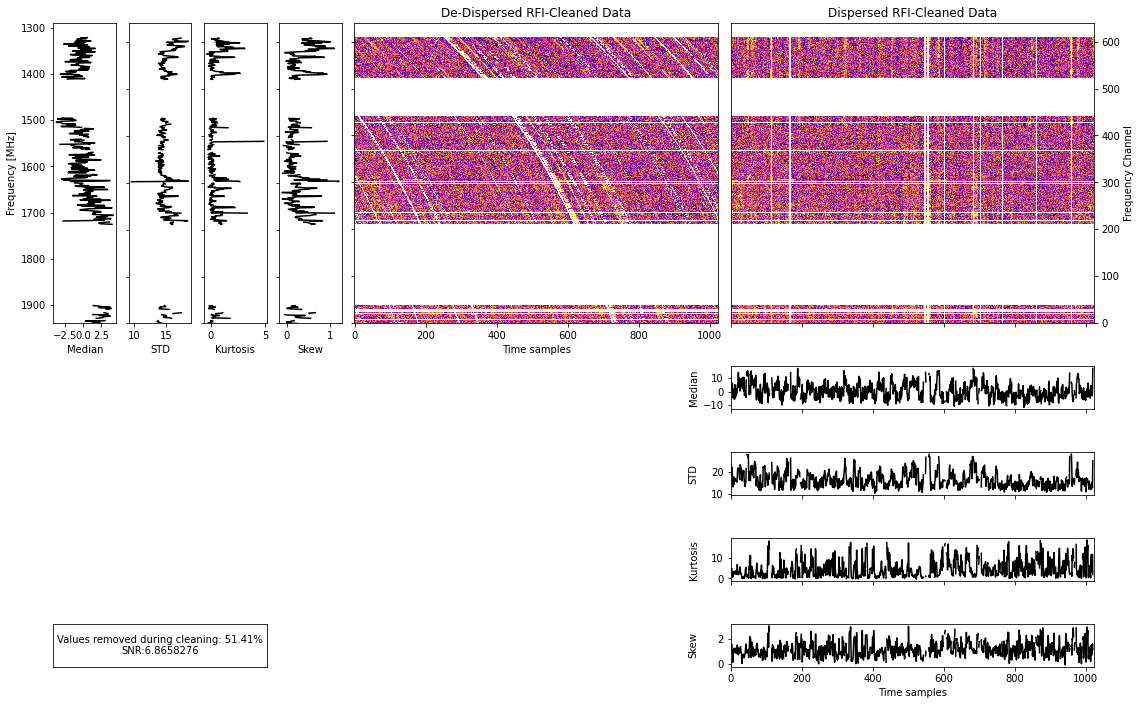

In [33]:
file_path = '/srv/storage_11/galc/UBB/jtremblay/singlepulse/pulse_3280414870.ar'
zapped_file = 'B0355+54_zapped_freqs.txt'
#file_path = '/srv/storage_11/galc/UBB/jtremblay/singlepulse/filtool_cleaned_files/pulse_3280414829.ar'
#file_path  = '/srv/storage_11/galc/UBB/jtremblay/20230921/J1713+0747/folded_data/1614.84375/21:32:22_0016.ar'
result_array = clean_and_plot(file_path, zapped_file, threshold_dedisp = 0.01, threshold_disp = 0.01, on_pulse_start = 10, on_pulse_end = 50, \
               folded = False, plot_compact_initial_stats = False, plot_compact_stats = True) #threshold_dedisp = 5, threshold_disp = 15

In [34]:
def find_freq_subarrays_with_nan(arr):
    nan_indexes = []
    for i, subarray in enumerate(arr):
        if np.all(np.isnan(subarray)):
            nan_indexes.append(i)  # Append the index of the subarray with all NaN values
    return nan_indexes  # Return the list of indexes with all NaN values

In [35]:
zapped_freqs_from_result_array = find_freq_subarrays_with_nan(result_array)
print(np.shape(result_array))
print(zapped_freqs_from_result_array)
np.savetxt('nan_indexes.txt', np.array(zapped_freqs_from_result_array, dtype=int), fmt='%d')

(640, 1024)
[7, 8, 10, 20, 24, 26, 27, 28, 29, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 217, 234, 296, 300, 301, 318, 319, 365, 366, 367, 369, 380, 389, 393, 395, 416, 426, 438, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


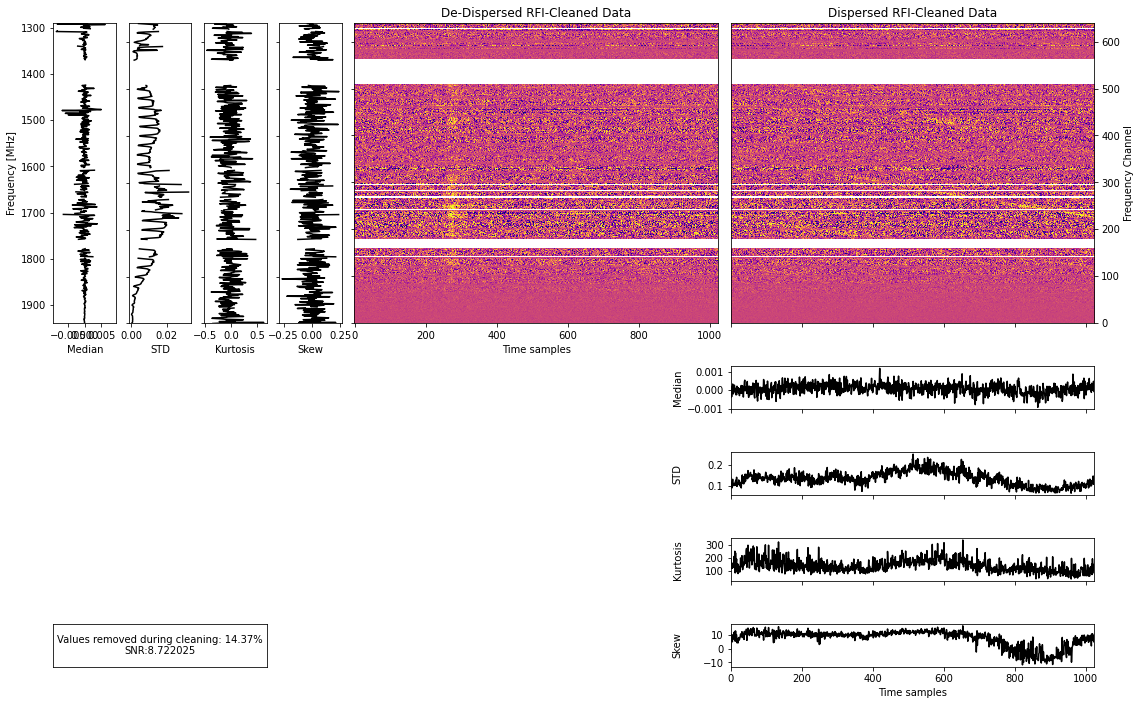

In [74]:
#file_path = '/srv/storage_11/galc/UBB/jtremblay/singlepulse/pulse_3280414829.ar'
#file_path = '/srv/storage_11/galc/UBB/jtremblay/singlepulse/filtool_cleaned_files/pulse_3280414829.ar'
file_path  = '/srv/storage_11/galc/UBB/jtremblay/20230921/J1713+0747/folded_data/1614.84375/21:32:22_0016.ar'
zapped_file = 'J1713+0747_zapped_freqs.txt'
result_array = clean_and_plot(file_path, zapped_file, threshold_dedisp = 0.01, threshold_disp = 1000, on_pulse_start = 210, on_pulse_end = 300, \
               folded = True, plot_compact_initial_stats = False, plot_compact_stats = True)
list_of_zaps = find_nan_indices(result_array) #This gives us a list of all the zapped values

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


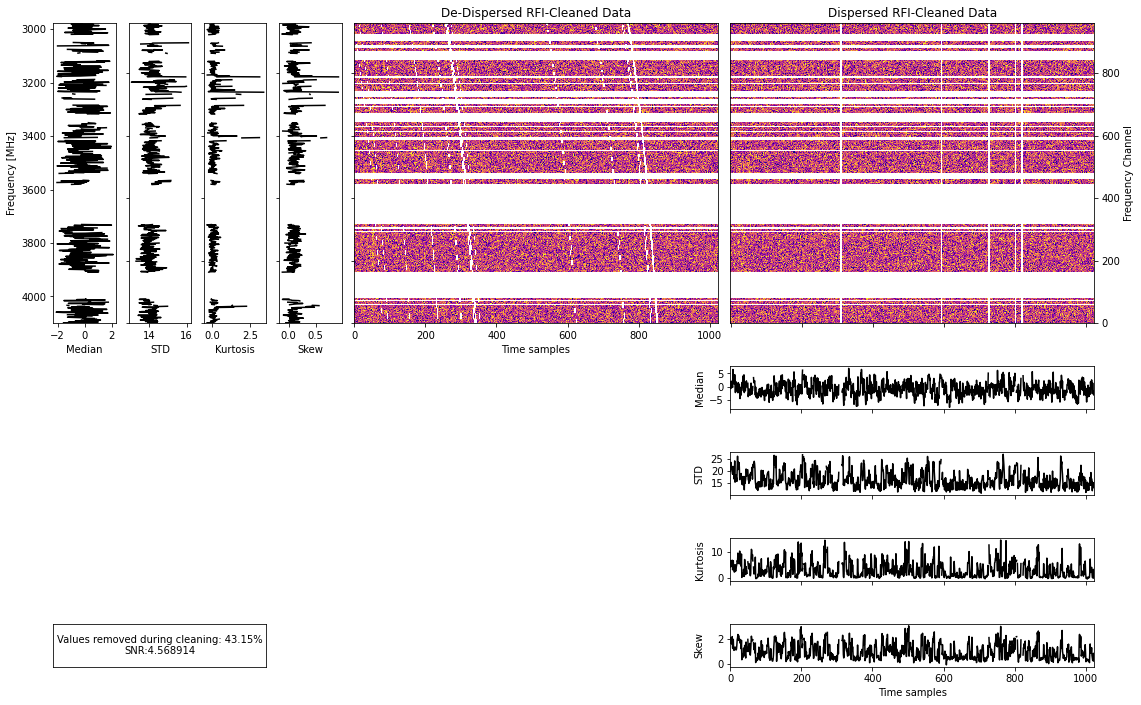

In [37]:
file_path = '/srv/storage_11/galc/UBB/jtremblay/singlepulse/search3/pulse_3280416494.ar'
zapped_file = 'B0355+54_zapped_search3.txt'
result_array = clean_and_plot(file_path, zapped_file, threshold_dedisp = 0.01, threshold_disp = 15, on_pulse_start = 10, on_pulse_end = 50, \
               plot_compact_initial_stats = False, plot_compact_stats = True)

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


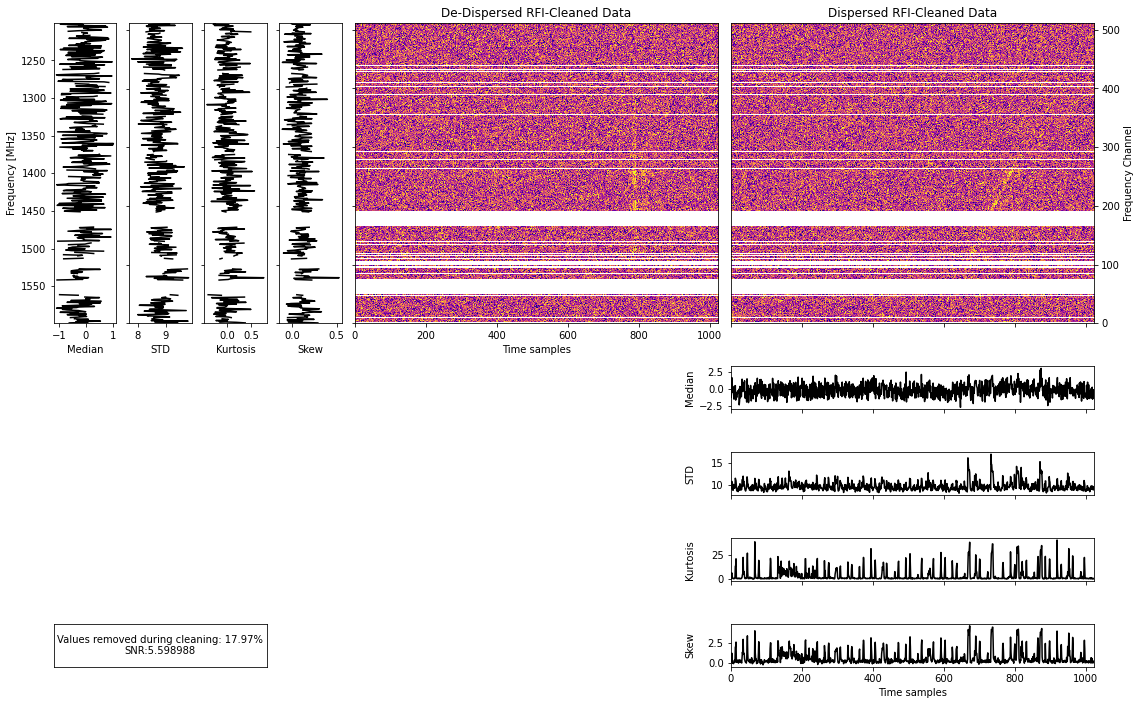

In [76]:
file_path  = '/srv/storage_11/galc/UBB/jtremblay/20231227/singlepulse/pulse_3430703646.ar'
zapped_file = '/srv/storage_11/galc/UBB/jtremblay/20231227/singlepulse/B0355+54_zapped_freqs.txt'
result_array = clean_and_plot(file_path, zapped_file, threshold_dedisp = 1, threshold_disp = 1000, on_pulse_start = 750, on_pulse_end = 850, \
               folded = False, plot_compact_initial_stats = False, plot_compact_stats = True)
list_of_zaps = find_nan_indices(result_array) #This gives us a list of all the zapped values